# Telecom Churn Prediction - Starter Notebook

**Author:** Akshay Sehgal (www.akshaysehgal.com)

The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [1]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [2]:
#COMMENT THIS SECTION INCASE RUNNING THIS NOTEBOOK LOCALLY

#Checking the kaggle paths for the uploaded datasets
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [4]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


For the purpose of this **starter notebook**, we I will restrict the dataset to only a small set of variables. 

The approach I use here is to understand each Acronym, figure our what variable might be important and filter out variable names based on the combinations of acrynoms using REGEX. So, if I want the total minutes a person has spent on outgoing calls, I need acronyms, TOTAL, OG and MOU. So corresponding regex is ```total.+og.+mou```

In [5]:
ids = ['id','circle_id']
total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]

#Storing them in a single flat list
variables = [*ids, 
             *total_amounts, 
             *total_outgoing_minutes, 
             *offnetwork_minutes, 
             *average_revenue_3g, 
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network, 
             'churn_probability']

data = data[variables].set_index('id')

In [6]:
data.head()

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
id,,,,,,,,,,,,,,,,,,,,,
0,109,77,65,10,81.21,221.68,3.63,32.24,96.68,2.33,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,1958,0
1,109,0,145,50,0.00,30.73,31.66,0.00,25.99,30.89,...,122.08,NaN,0.0,3.96,0.0,0.0,352.91,0.00,710,0
2,109,70,120,0,56.49,99.36,0.00,53.99,82.05,0.00,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,882,0
3,109,160,240,130,76.03,95.98,53.84,68.76,78.48,50.23,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,982,0
4,109,290,136,122,63.26,42.94,15.76,56.99,38.11,9.63,...,35.12,0.0,0.0,0.00,0.0,390.8,308.89,213.47,647,0


Let's look at each variable's datatype:

In [7]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69999 entries, 0 to 69998
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   circle_id          69999 non-null  int64  
 1   total_rech_amt_6   69999 non-null  int64  
 2   total_rech_amt_7   69999 non-null  int64  
 3   total_rech_amt_8   69999 non-null  int64  
 4   total_og_mou_6     69999 non-null  float64
 5   total_og_mou_7     69999 non-null  float64
 6   total_og_mou_8     69999 non-null  float64
 7   offnet_mou_6       67231 non-null  float64
 8   offnet_mou_7       67312 non-null  float64
 9   offnet_mou_8       66296 non-null  float64
 10  arpu_3g_6          17568 non-null  float64
 11  arpu_3g_7          17865 non-null  float64
 12  arpu_3g_8          18417 non-null  float64
 13  arpu_2g_6          17568 non-null  float64
 14  arpu_2g_7          17865 non-null  float64
 15  arpu_2g_8          18417 non-null  float64
 16  vol_3g_mb_6        699

Let's also summarize the features using the df.describe method:

In [8]:
data.describe(include="all")

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
count,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,...,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,109.0,328.139788,322.376363,323.846355,306.451436,310.572674,304.513065,198.874771,197.153383,196.543577,...,85.846074,86.348404,122.171882,128.934444,135.486541,51.773924,51.240204,50.127506,1220.639709,0.101887
std,0.0,404.211068,411.070120,426.181405,465.502866,479.131770,477.936832,316.818355,322.482226,324.089234,...,178.067280,170.297094,554.869965,554.096072,568.310234,212.513909,211.114667,213.101403,952.426321,0.302502
min,109.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-13.090000,-55.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000
25%,109.0,110.000000,100.000000,90.000000,44.780000,42.910000,38.710000,34.860000,32.240000,31.575000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000
50%,109.0,229.000000,220.000000,225.000000,145.280000,141.230000,138.360000,96.480000,91.885000,91.800000,...,8.800000,9.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.000000
75%,109.0,438.000000,430.000000,436.000000,374.305000,380.045000,370.895000,232.990000,227.630000,229.345000,...,122.070000,122.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,0.000000
max,109.0,35190.000000,40335.000000,45320.000000,10674.030000,8285.640000,14043.060000,8362.360000,7043.980000,14007.340000,...,4809.360000,3483.170000,45735.400000,28144.120000,30036.060000,10285.900000,7873.550000,11117.610000,4337.000000,1.000000


## 2.  Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations

In [9]:
data.isna().sum().sort_values()

circle_id                0
vol_2g_mb_8              0
vol_2g_mb_7              0
vol_2g_mb_6              0
vol_3g_mb_8              0
vol_3g_mb_7              0
vol_3g_mb_6              0
aon                      0
churn_probability        0
total_og_mou_8           0
total_og_mou_7           0
total_og_mou_6           0
total_rech_amt_8         0
total_rech_amt_7         0
total_rech_amt_6         0
offnet_mou_7          2687
offnet_mou_6          2768
offnet_mou_8          3703
arpu_3g_8            51582
arpu_2g_8            51582
arpu_2g_7            52134
arpu_3g_7            52134
arpu_3g_6            52431
arpu_2g_6            52431
dtype: int64

In [10]:
# Checking the percentage of missing values
round(100*(data.isnull().sum()/len(data.index)), 2)

circle_id             0.00
total_rech_amt_6      0.00
total_rech_amt_7      0.00
total_rech_amt_8      0.00
total_og_mou_6        0.00
total_og_mou_7        0.00
total_og_mou_8        0.00
offnet_mou_6          3.95
offnet_mou_7          3.84
offnet_mou_8          5.29
arpu_3g_6            74.90
arpu_3g_7            74.48
arpu_3g_8            73.69
arpu_2g_6            74.90
arpu_2g_7            74.48
arpu_2g_8            73.69
vol_3g_mb_6           0.00
vol_3g_mb_7           0.00
vol_3g_mb_8           0.00
vol_2g_mb_6           0.00
vol_2g_mb_7           0.00
vol_2g_mb_8           0.00
aon                   0.00
churn_probability     0.00
dtype: float64

<AxesSubplot:>

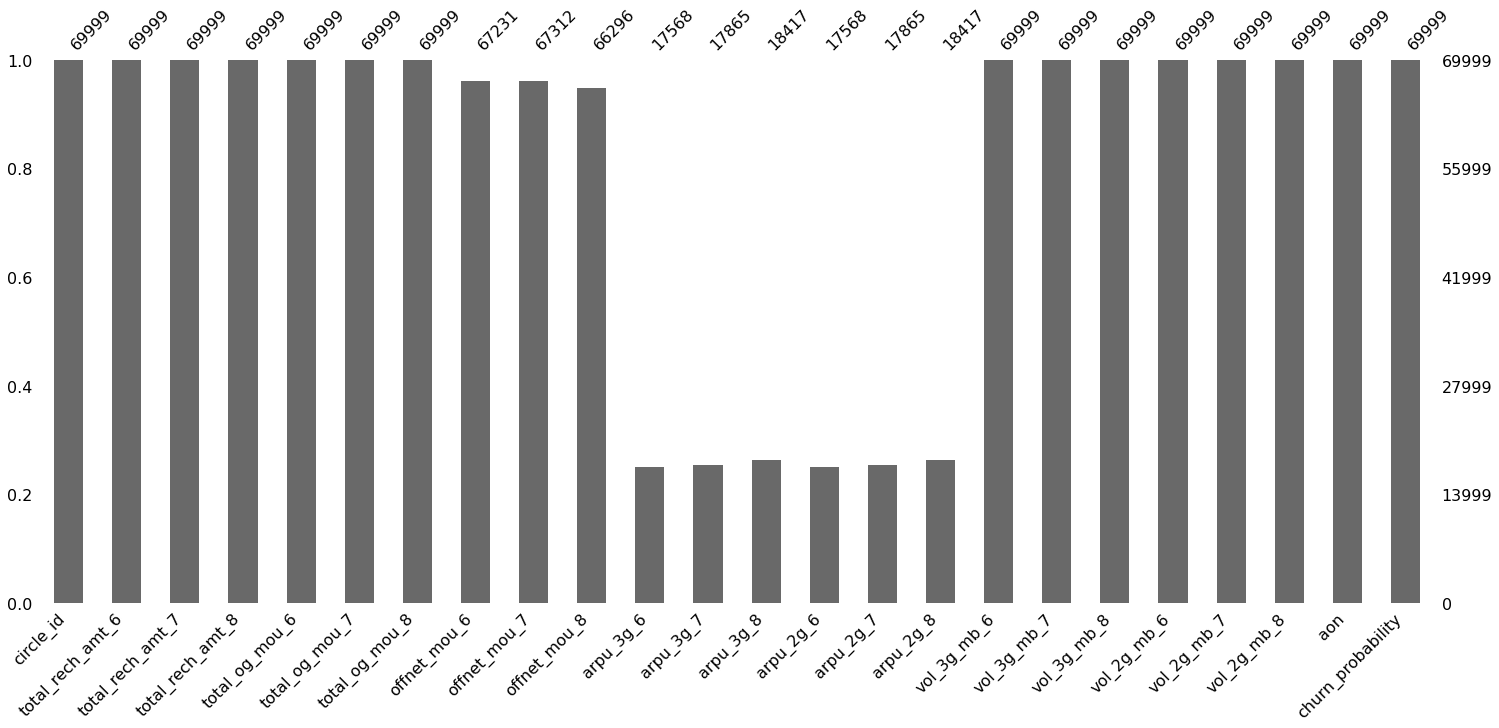

In [11]:
msno.bar(data)

<AxesSubplot:>

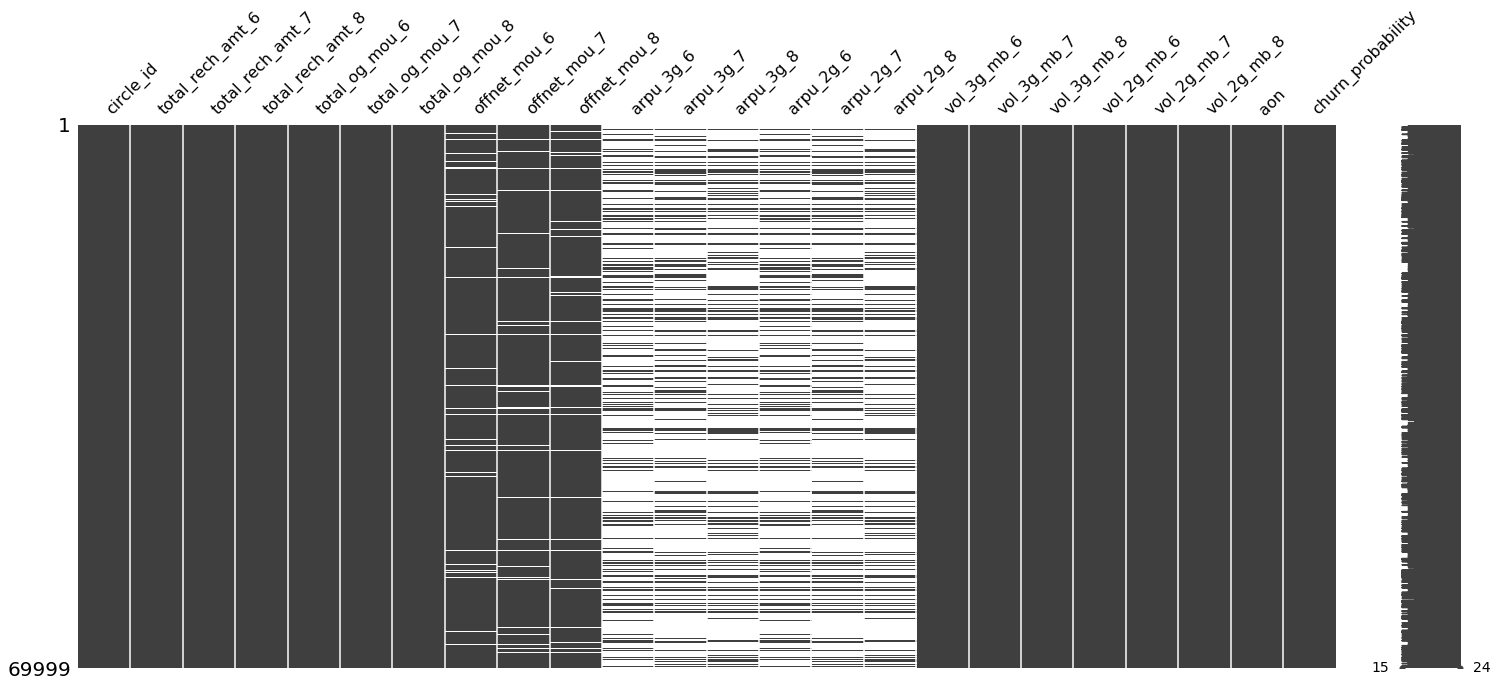

In [12]:
msno.matrix(data)

<AxesSubplot:>

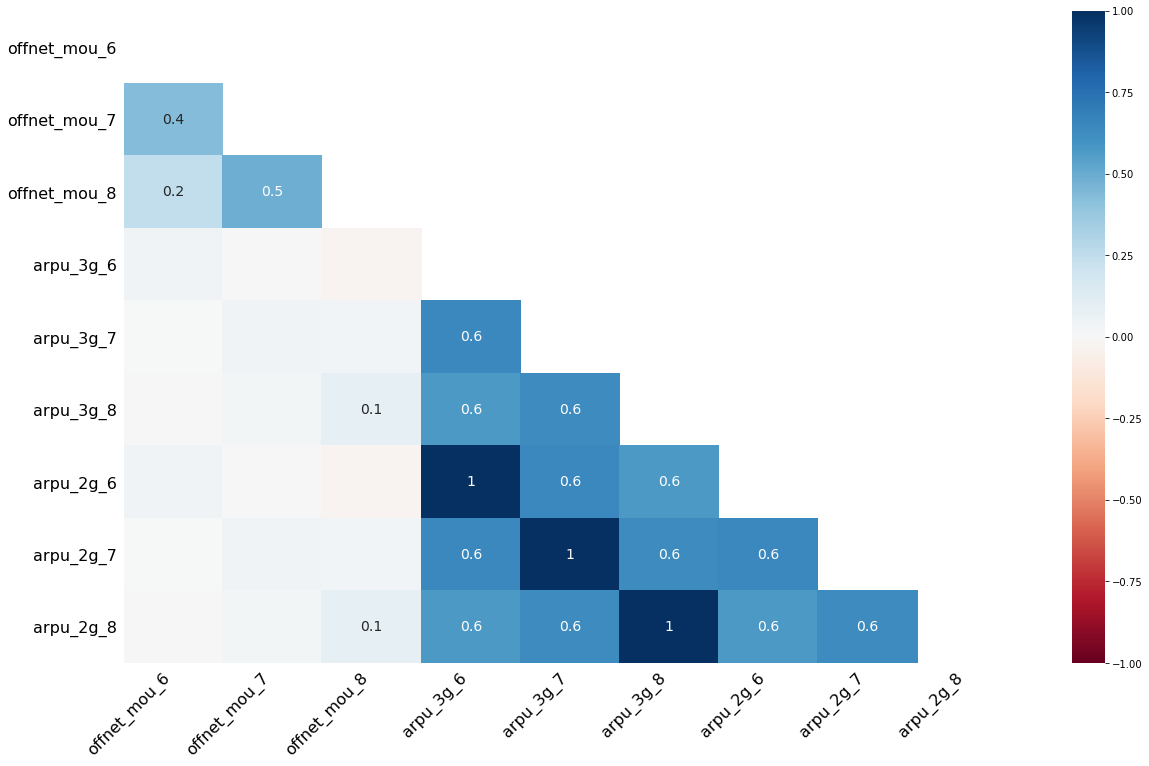

In [13]:
msno.heatmap(data)

In [14]:
# Drop all the columns in which greater than 5200 missing values are present

for col in data.columns:
    if data[col].isnull().sum() > 5200:
        data.drop(col, 1, inplace=True)

In [15]:
data.shape

(69999, 18)

In [16]:
# Checking the percentage of missing values
round(100*(data.isnull().sum()/len(data.index)), 2)

circle_id            0.00
total_rech_amt_6     0.00
total_rech_amt_7     0.00
total_rech_amt_8     0.00
total_og_mou_6       0.00
total_og_mou_7       0.00
total_og_mou_8       0.00
offnet_mou_6         3.95
offnet_mou_7         3.84
offnet_mou_8         5.29
vol_3g_mb_6          0.00
vol_3g_mb_7          0.00
vol_3g_mb_8          0.00
vol_2g_mb_6          0.00
vol_2g_mb_7          0.00
vol_2g_mb_8          0.00
aon                  0.00
churn_probability    0.00
dtype: float64

In [17]:
# Checking if there are columns with one unique value since it won't affect our analysis
data.nunique(dropna=True)
data.shape

(69999, 18)

In [18]:
data.isnull().sum().sort_values(ascending = False)

offnet_mou_8         3703
offnet_mou_6         2768
offnet_mou_7         2687
vol_3g_mb_6             0
aon                     0
vol_2g_mb_8             0
vol_2g_mb_7             0
vol_2g_mb_6             0
vol_3g_mb_8             0
vol_3g_mb_7             0
circle_id               0
total_rech_amt_6        0
total_og_mou_8          0
total_og_mou_7          0
total_og_mou_6          0
total_rech_amt_8        0
total_rech_amt_7        0
churn_probability       0
dtype: int64

In [19]:
data.describe()

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
count,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,109.0,328.139788,322.376363,323.846355,306.451436,310.572674,304.513065,198.874771,197.153383,196.543577,122.171882,128.934444,135.486541,51.773924,51.240204,50.127506,1220.639709,0.101887
std,0.0,404.211068,411.070120,426.181405,465.502866,479.131770,477.936832,316.818355,322.482226,324.089234,554.869965,554.096072,568.310234,212.513909,211.114667,213.101403,952.426321,0.302502
min,109.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000
25%,109.0,110.000000,100.000000,90.000000,44.780000,42.910000,38.710000,34.860000,32.240000,31.575000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000
50%,109.0,229.000000,220.000000,225.000000,145.280000,141.230000,138.360000,96.480000,91.885000,91.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.000000
75%,109.0,438.000000,430.000000,436.000000,374.305000,380.045000,370.895000,232.990000,227.630000,229.345000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,0.000000
max,109.0,35190.000000,40335.000000,45320.000000,10674.030000,8285.640000,14043.060000,8362.360000,7043.980000,14007.340000,45735.400000,28144.120000,30036.060000,10285.900000,7873.550000,11117.610000,4337.000000,1.000000


In [20]:
# Drop the null values rows in the column 'offnet_mou_8'
data = data[~pd.isnull(data["offnet_mou_8"])]
# Drop the null values rows in the column 'offnet_mou_7'
data = data[~pd.isnull(data["offnet_mou_7"])]
# Drop the null values rows in the column 'offnet_mou_6'
data = data[~pd.isnull(data["offnet_mou_6"])]
data.isnull().sum().sort_values(ascending = False)

circle_id            0
total_rech_amt_6     0
aon                  0
vol_2g_mb_8          0
vol_2g_mb_7          0
vol_2g_mb_6          0
vol_3g_mb_8          0
vol_3g_mb_7          0
vol_3g_mb_6          0
offnet_mou_8         0
offnet_mou_7         0
offnet_mou_6         0
total_og_mou_8       0
total_og_mou_7       0
total_og_mou_6       0
total_rech_amt_8     0
total_rech_amt_7     0
churn_probability    0
dtype: int64

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63842 entries, 0 to 69998
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   circle_id          63842 non-null  int64  
 1   total_rech_amt_6   63842 non-null  int64  
 2   total_rech_amt_7   63842 non-null  int64  
 3   total_rech_amt_8   63842 non-null  int64  
 4   total_og_mou_6     63842 non-null  float64
 5   total_og_mou_7     63842 non-null  float64
 6   total_og_mou_8     63842 non-null  float64
 7   offnet_mou_6       63842 non-null  float64
 8   offnet_mou_7       63842 non-null  float64
 9   offnet_mou_8       63842 non-null  float64
 10  vol_3g_mb_6        63842 non-null  float64
 11  vol_3g_mb_7        63842 non-null  float64
 12  vol_3g_mb_8        63842 non-null  float64
 13  vol_2g_mb_6        63842 non-null  float64
 14  vol_2g_mb_7        63842 non-null  float64
 15  vol_2g_mb_8        63842 non-null  float64
 16  aon                638

<AxesSubplot:>

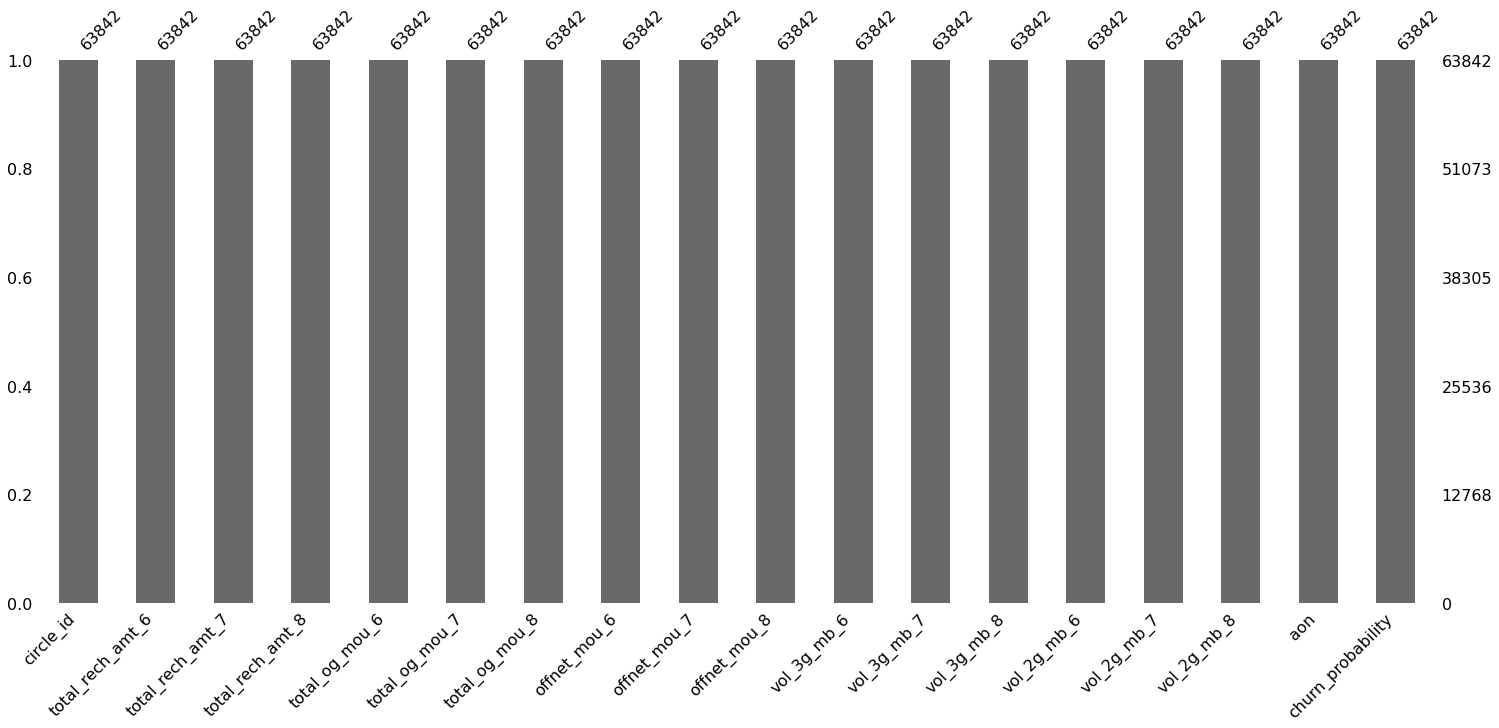

In [22]:
msno.bar(data)

# 3. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<AxesSubplot:xlabel='churn_probability', ylabel='count'>

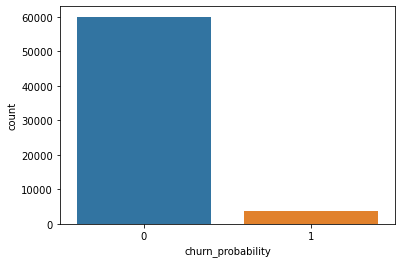

In [23]:
sns.countplot(x="churn_probability",data = data)

<AxesSubplot:>

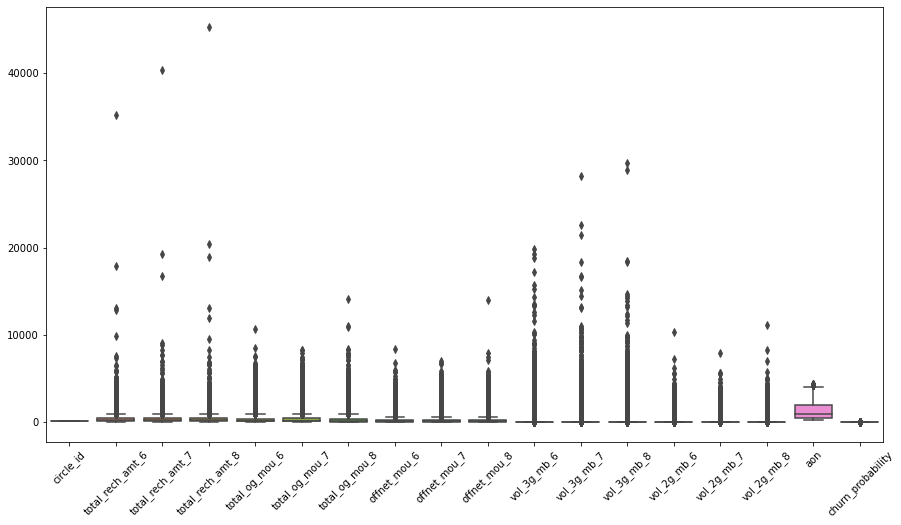

In [24]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = data)

Handling outliers

In [25]:
# Capping the outliers
for col in data.columns:
    percentiles = data[col].quantile([0.01, 0.99]).values
    data[col][data[col] <= percentiles[0]] = percentiles[0]
    data[col][data[col] >= percentiles[1]] = percentiles[1]

<AxesSubplot:>

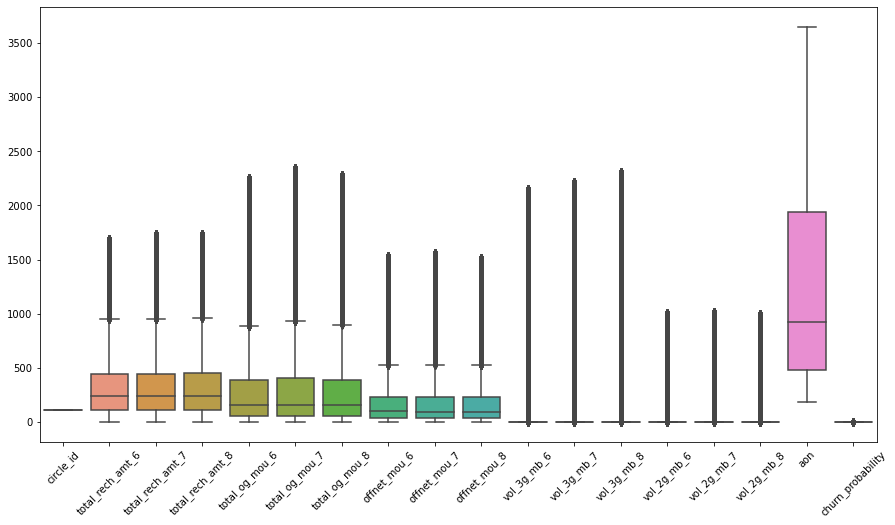

In [26]:


plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = data)

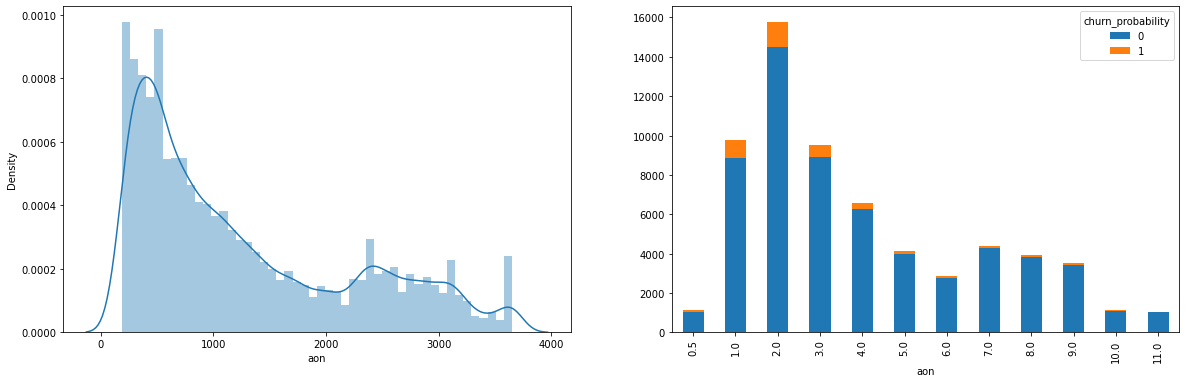

In [27]:
# Age on Network
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 6))

# distribution plot for aon
sns.distplot(data['aon'], ax=ax1)

# bin the aon column with yearwise segments and plot the counts for each segments
bins = [0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
labels = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
#sns.countplot(pd.cut(round(((data['aon']/30)/12),1), bins = bins, labels = labels ), ax =ax1)
pd.crosstab(pd.cut(round(((data['aon']/30)/12),1), bins = bins, labels = labels ), data['churn_probability']).plot(kind='bar', stacked=True, ax = ax2)
plt.show()

- We can see more number of obervations between 1 and 3 years
- The churn rate is also higher in this time than the others

,total_og_mou_6
count,63842.000000
mean,310.225339
std,414.368027
min,0.000000
25%,55.360000
50%,156.710000
75%,387.917500
max,2255.598500


,total_og_mou_7
count,63842.000000
mean,320.856955
std,430.164578
min,0.000000
25%,55.910000
50%,158.420000
75%,405.117500
max,2346.399200


,total_og_mou_8
count,63842.000000
mean,311.832518
std,420.706568
min,0.000000
25%,52.240000
50%,153.060000
75%,391.347500
max,2276.931800


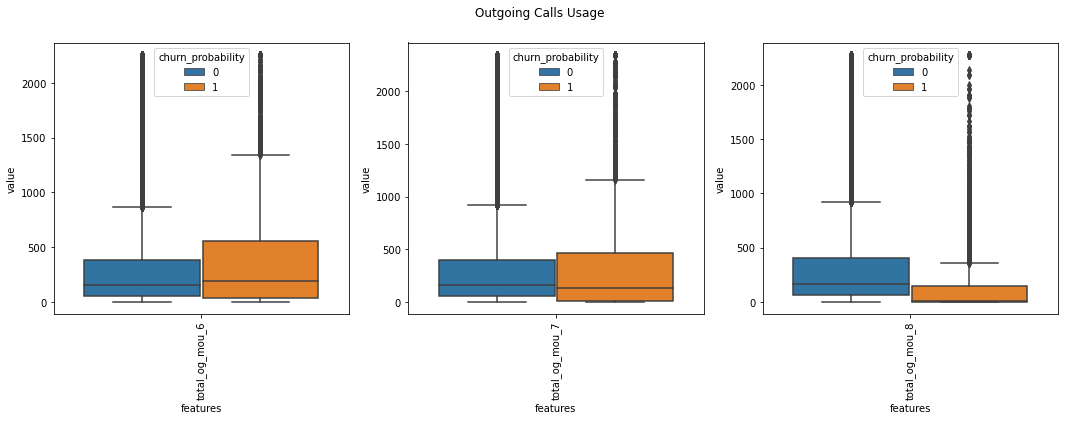

In [28]:
#Total Ougoing Usage
cols = [['total_og_mou_6'],
        ['total_og_mou_7'],
        ['total_og_mou_8']]
# column description stats
for i in range(0,3):
    display(data[cols[i]].describe())

# plot for the outgoing calls usage
plt.figure(figsize=(18, 5))
#ic call usage
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([data[cols[i]], data['churn_probability']], axis=1)
    X = pd.melt(X,id_vars="churn_probability",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn_probability", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Outgoing Calls Usage')

count    63842.000000
mean       330.528665
std        323.526528
min          0.000000
25%        110.000000
50%        239.000000
75%        447.000000
max       1687.000000
Name: total_rech_amt_6, dtype: float64

count    63842.000000
mean       331.030043
std        329.147526
min          0.000000
25%        110.000000
50%        238.000000
75%        446.750000
max       1738.590000
Name: total_rech_amt_7, dtype: float64

count    63842.000000
mean       331.754942
std        330.099106
min          0.000000
25%        111.000000
50%        240.000000
75%        451.000000
max       1733.000000
Name: total_rech_amt_8, dtype: float64

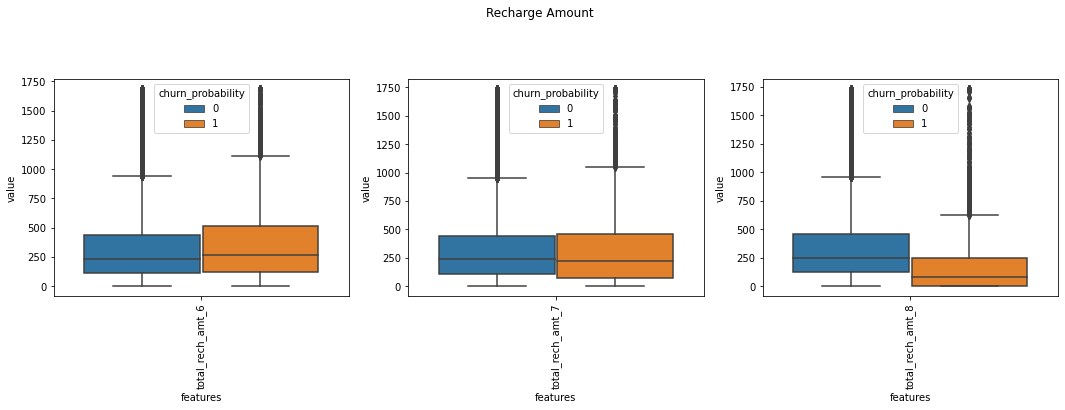

In [29]:
# Recharge Amount
cols = ['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8']
# column description stats
for i in range(0,3):
    display(data[cols[i]].describe())

# plot for the recharge count columns
plt.figure(figsize=(18, 10))
plt.subplots_adjust(hspace=0.5)
for i in range(0,3):
    plt.subplot(2,3,i+1)
    X = pd.concat([data[cols[i]], data['churn_probability']], axis=1)
    X = pd.melt(X,id_vars="churn_probability",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn_probability", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Recharge Amount')

count    63842.000000
mean       330.528665
std        323.526528
min          0.000000
25%        110.000000
50%        239.000000
75%        447.000000
max       1687.000000
Name: total_rech_amt_6, dtype: float64

count    63842.000000
mean       331.030043
std        329.147526
min          0.000000
25%        110.000000
50%        238.000000
75%        446.750000
max       1738.590000
Name: total_rech_amt_7, dtype: float64

count    63842.000000
mean       331.754942
std        330.099106
min          0.000000
25%        111.000000
50%        240.000000
75%        451.000000
max       1733.000000
Name: total_rech_amt_8, dtype: float64

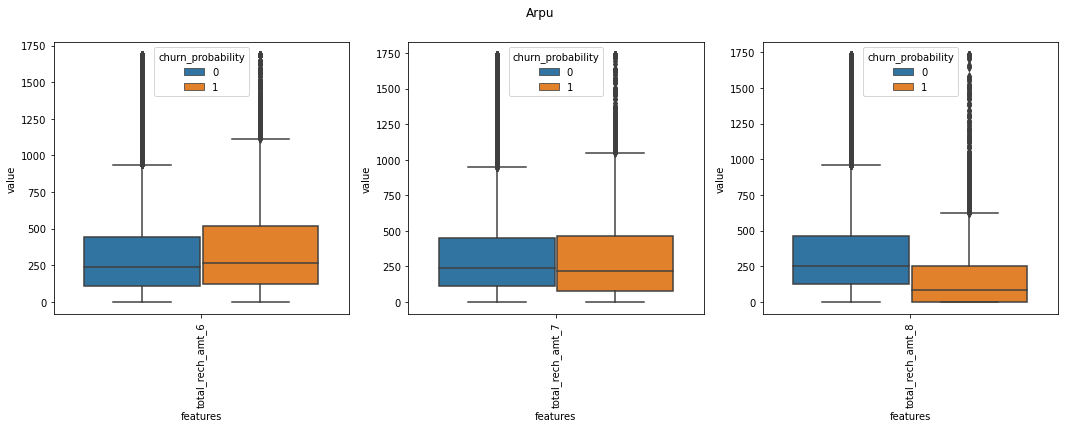

In [30]:
# Average Revenue
        

# column description stats
for i in range(0,3):
    display(data[cols[i]].describe())

# plot for the arpu
plt.figure(figsize=(18, 5))
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([data[cols[i]], data['churn_probability']], axis=1)
    X = pd.melt(X,id_vars="churn_probability",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn_probability", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Arpu')

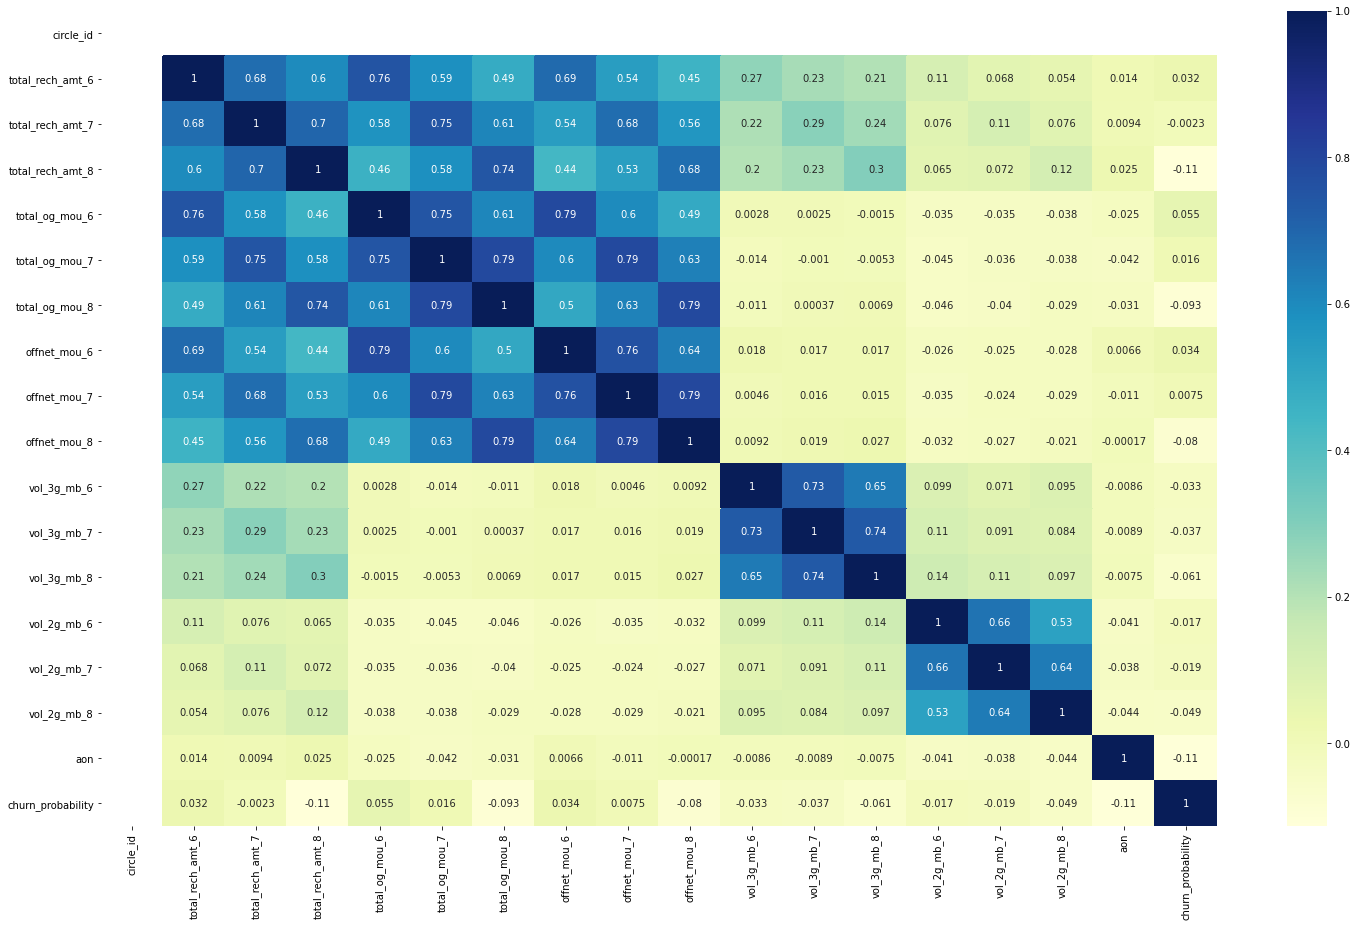

In [31]:
# Looking at the correlation table
plt.figure(figsize = (25,15))
sns.heatmap(data.corr(),cmap="YlGnBu", annot=True)
plt.show()

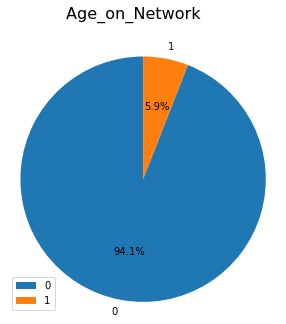

In [32]:
fig = plt.figure(figsize=[8, 5])
fig.suptitle('Age_on_Network ', fontsize=16)

plt.pie(data.churn_probability.value_counts(), labels=data.churn_probability.value_counts().index, autopct="%.1f%%", startangle=90);
plt.axis('square')
plt.legend(loc='lower left');

# 4. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [ ]:
data['circle_id'].unique()

In [33]:
X = data.drop('churn_probability', axis=1)
Y = data['churn_probability']

X.shape, Y.shape

((63842, 17), (63842,))

Splitting train and test data to avoid any contamination of the test data

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(51073, 17) (51073,)
(12769, 17) (12769,)


In [35]:
X_train.head()

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
id,,,,,,,,,,,,,,,,,
32604,109,252,244.00,109,412.48,377.8600,161.3600,336.660,318.1400,112.090,0.00,0.00,0.00,0.00,0.0,0.00,821
33402,109,1487,1738.59,1517,2114.33,2346.3992,2276.9318,1534.619,1557.7517,1518.013,0.00,0.00,0.00,0.00,0.0,0.00,1206
44161,109,0,160.00,100,125.56,56.9300,91.5800,74.660,41.4100,68.210,0.00,0.00,0.00,0.00,0.0,0.00,970
23682,109,1107,1347.00,1025,1024.69,1455.0300,1317.8800,205.060,258.4300,114.690,408.77,568.78,359.55,124.98,0.0,9.18,490
46755,109,353,80.00,519,416.26,73.4600,87.7600,269.040,54.4900,35.180,0.00,0.00,1021.59,0.00,0.0,1.15,476


In [36]:
missing_data_percent = 100*X_train.isnull().sum()/len(Y_train)

In [37]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['circle_id', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon'],
      dtype='object')

In [38]:
X_train_filtered = X_train[new_vars]
X_train_filtered.shape

(51073, 17)

In [39]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index([], dtype='object')

In [40]:
X_train_filtered.describe()

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
count,51073.0,51073.000000,51073.000000,51073.000000,51073.000000,51073.000000,51073.000000,51073.000000,51073.000000,51073.000000,51073.000000,51073.000000,51073.000000,51073.000000,51073.000000,51073.000000,51073.000000
mean,109.0,330.012139,330.913063,331.409825,309.831618,320.657821,311.306525,191.156348,193.850845,188.494006,103.336187,113.705401,120.566538,47.089133,46.948288,46.039015,1263.263642
std,0.0,324.065555,329.489300,330.470366,414.174057,429.668076,420.294033,264.885659,271.868078,264.997127,344.826696,366.269376,378.277916,157.800468,158.222633,155.519606,961.867860
min,109.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,189.000000
25%,109.0,110.000000,110.000000,110.000000,54.930000,55.680000,51.940000,35.340000,34.030000,31.780000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,480.000000
50%,109.0,238.000000,238.000000,240.000000,156.760000,158.660000,153.080000,96.710000,94.790000,91.840000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,926.000000
75%,109.0,446.000000,447.000000,450.000000,386.860000,406.010000,391.090000,231.880000,233.440000,229.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1939.000000
max,109.0,1687.000000,1738.590000,1733.000000,2255.598500,2346.399200,2276.931800,1534.619000,1557.751700,1518.013000,2151.103100,2220.646200,2306.933900,1004.998000,1016.071400,998.818700,3651.000000


Scaling

In [42]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)

<AxesSubplot:xlabel='churn_probability', ylabel='Count'>

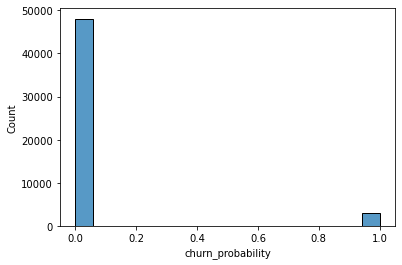

In [41]:
#Distribution for the churn probability
sns.histplot(Y_train)

# 5. Model Building

PCA

In [43]:
#initialize the pca with randomized
pca = PCA()
# fit the training dataset
pca.fit(X_train)

PCA()

In [44]:
pca.components_

array([[ 0.00000000e+00,  3.20235082e-01,  3.39445591e-01,
         3.18487757e-01,  3.24889029e-01,  3.50738694e-01,
         3.32615220e-01,  3.20790261e-01,  3.42320491e-01,
         3.26209146e-01,  6.53390433e-02,  7.23166842e-02,
         7.25057712e-02,  9.19846212e-03,  1.08898145e-02,
         1.10379086e-02, -2.28078371e-03],
       [-0.00000000e+00,  9.52294823e-02,  1.01996822e-01,
         1.08958055e-01, -1.01840872e-01, -1.12985747e-01,
        -1.01721927e-01, -9.54465960e-02, -1.05956673e-01,
        -9.34455591e-02,  4.36362178e-01,  4.57301020e-01,
         4.49388680e-01,  3.27198412e-01,  3.22790349e-01,
         3.04864283e-01, -2.05305009e-02],
       [-0.00000000e+00, -2.06606665e-02, -1.15480709e-02,
        -1.81433800e-02,  2.91216435e-02,  3.93869186e-02,
         3.25831055e-02,  3.20158245e-02,  3.95107748e-02,
         3.25375565e-02, -3.26106873e-01, -3.32977760e-01,
        -3.00643677e-01,  4.55283550e-01,  5.05420211e-01,
         4.67741626e-01, -5.3

In [45]:
pca.explained_variance_ratio_

array([0.38251877, 0.17409165, 0.12508569, 0.06277091, 0.05859847,
       0.03676592, 0.02995636, 0.0287372 , 0.02276756, 0.02203183,
       0.01888627, 0.01471443, 0.00821384, 0.00743339, 0.00487813,
       0.00254956, 0.        ])

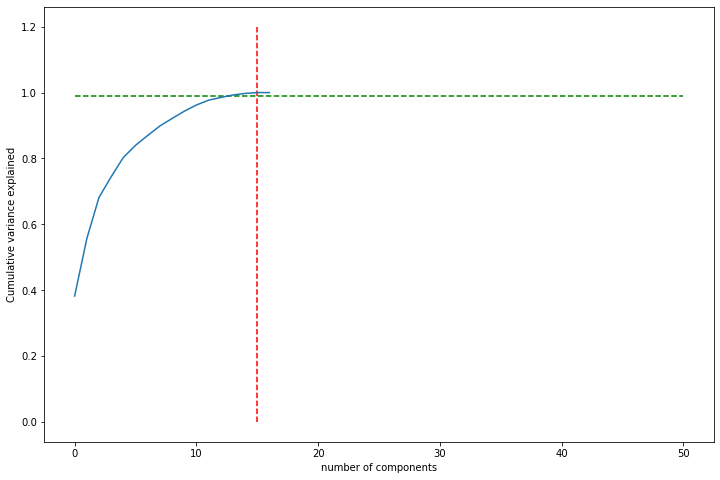

In [46]:
#Screeplot for the PCA components
fig = plt.figure(figsize=[12,8])
plt.vlines(x=15, ymax=1.2, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.99, xmax=50, xmin=0, colors="g", linestyles="--")
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('Cumulative variance explained')
plt.show()

In [ ]:
# We will perform with 15 components

In [47]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=15)

In [48]:
df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

(51073, 15)

<AxesSubplot:>

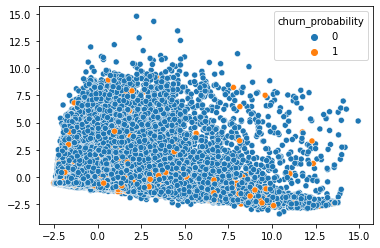

In [49]:
sns.scatterplot(x=df_train_pca[:,0], y=df_train_pca[:,1], hue=Y_train)

In [51]:
#correlation matrix
corrmat = np.corrcoef(df_train_pca.transpose())

In [52]:
#correlation matrix shape
corrmat.shape

(15, 15)

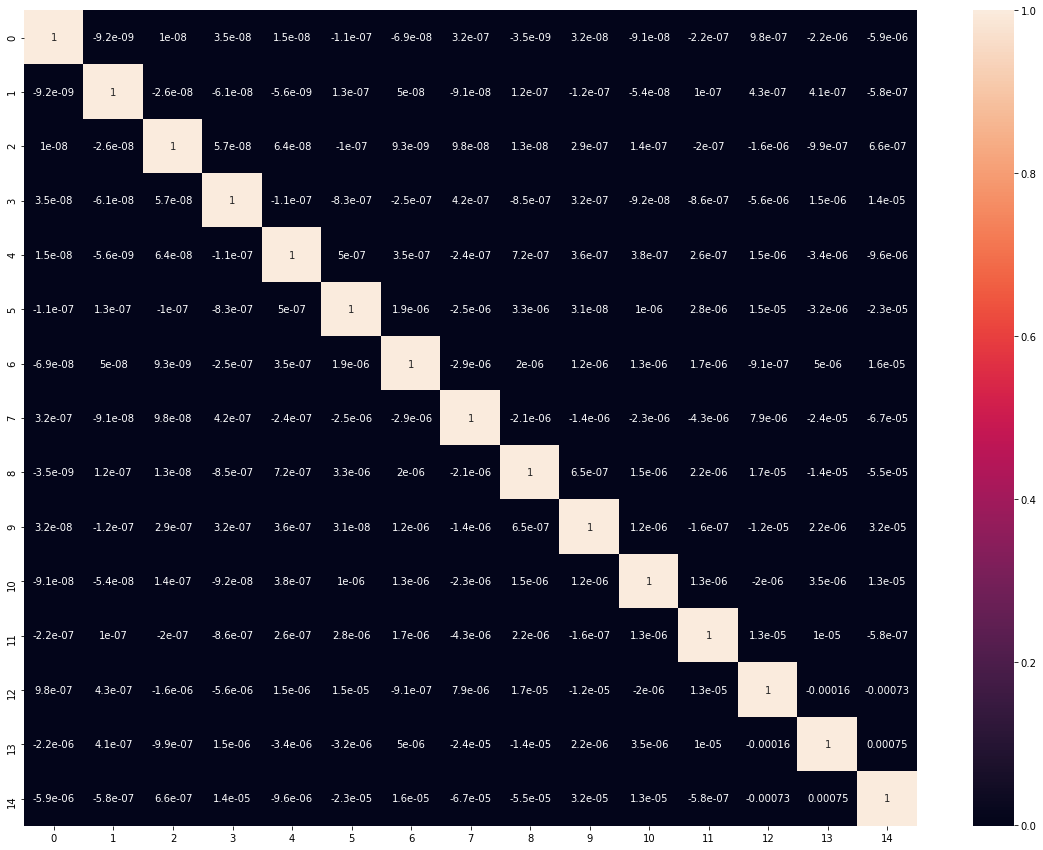

In [53]:
#Plotting the heatmap of the corr matrix
plt.figure(figsize=[20,15])
sns.heatmap(corrmat, annot=True)
plt.show()

There is no  correlation 

In [ ]:
#Applying the transformation on the test set

In [54]:
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(12769, 15)

In [55]:
# fit and transform the whole dataset
X_pca = pca.fit_transform(X)

#### BASE LINE MODELLING

In [56]:
# List to store the model scores
model_score_list = []

In [57]:
# Will create a function and call it again and again for different models
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
def evaluate_model(actual, pred):
    # Accuracy Score
    acc_score = round(accuracy_score(actual, pred)*100,2)
    print('Accuracy Score : ',acc_score)
    # ROC AUC score
    roc_score = round(roc_auc_score(actual, pred)*100,2)
    print('ROC AUC score : ',roc_score)
    # Precision score
    prec_score = round(precision_score(actual, pred)*100,2)
    print('Precision score : ', prec_score)
    # Recall score
    rec_score = round(recall_score(actual, pred)*100,2)
    print('Recall score : ', rec_score)

    return acc_score, roc_score, prec_score, rec_score

## Logistic Regression

In [58]:
# Initialize the Logistic regression
model1 = LogisticRegression(class_weight='balanced', random_state=42)
# fit the pca training data
model1.fit(df_train_pca, Y_train)
# predict the testing pca data
Y_pred = model1.predict(df_test_pca)
# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list 
model_score_list.append({'model_name':'LogisticRegression', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})


Accuracy Score :  92.72
ROC AUC score :  59.07
Precision score :  30.88
Recall score :  21.03


In [59]:
# Confusion matrix 
from sklearn import metrics
import statsmodels.api as sm
confusion = metrics.confusion_matrix(Y_test, Y_pred )
confusion

array([[11685,   347],
       [  582,   155]], dtype=int64)

## Random Forest

In [60]:
# initialize the randomforest
model2 = RandomForestClassifier(class_weight='balanced', random_state=42)
# fit the pca training data
model2.fit(df_train_pca, Y_train)
# predict the pca testing data
Y_pred = model2.predict(df_test_pca)

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)
# add the model scores to score list
model_score_list.append({'model_name':'RandomForestClassifier', 'acc_score':acc_score, 'roc_score':roc_score, 'precision_score':prec_score, 'recall_score':rec_score})

Accuracy Score :  94.23
ROC AUC score :  50.0
Precision score :  0.0
Recall score :  0.0


#### Model Score List

In [69]:
# convert the model scores to dataframe
model_score_df = pd.DataFrame(model_score_list,columns=['model_name', 'acc_score', 'roc_score','precision_score','recall_score'])

# Order by highest recall score and roc_auc_score
model_score_df.sort_values(['acc_score','roc_score'], ascending=False)

,model_name,acc_score,roc_score,precision_score,recall_score
1,RandomForestClassifier,94.23,50.00,0.00,0.00
0,LogisticRegression,92.72,59.07,30.88,21.03


So, here we can see RANDOM FOREST CLASSIFIER is giving more Accuracy Score with 94.23%

### CROSS VALIDATION

In [70]:
#Cross val score for Logistic regression
from sklearn.model_selection import GridSearchCV,cross_val_score
cross_val_score(model1, X_train, Y_train, cv=5, n_jobs=-1)
cross_val_score(model1, X_train, Y_train, cv=5, n_jobs=-1).mean()

0.6814756976043074

In [71]:
#Cross val score for Random Forest Classifier
cross_val_score(model2, X_train, Y_train, cv=5, n_jobs=-1)
cross_val_score(model2, X_train, Y_train, cv=5, n_jobs=-1).mean()

0.9466645964322385

Since it is more important to identify churners than the non-churners accurately, we go with the RandomForestClassifier which has high accuracy score and CV score

### Hyperparameter tuning for RANDOMFOREST CLASSIFIER

In [74]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
hyper_params = {'max_depth': [3, 5, 10, 15, 20],
                'max_features': [ 5, 7, 11, 15, 20],
                'min_samples_leaf': [20, 50, 100, 200, 400],
                'n_estimators': [10, 25, 50, 80, 100]
               }

In [75]:
model_cv = GridSearchCV(estimator=rf, 
             param_grid=hyper_params,
             verbose=1,
             cv=5,
             n_jobs=-1,
             return_train_score=True)

In [76]:
model_cv.fit(X_train, Y_train)

Fitting 5 folds for each of 625 candidates, totalling 3125 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 15, 20],
                         'max_features': [5, 7, 11, 15, 20],
                         'min_samples_leaf': [20, 50, 100, 200, 400],
                         'n_estimators': [10, 25, 50, 80, 100]},
             return_train_score=True, verbose=1)

In [77]:
# print the grid results
print('\n Best estimator:')
print(model_cv.best_estimator_)
print('\n Best score:')
print(model_cv.best_score_ * 2 - 1)
print('\n Best parameters:')
print(model_cv.best_params_)


 Best estimator:
RandomForestClassifier(max_depth=20, max_features=11, min_samples_leaf=20,
                       n_jobs=-1, random_state=42)

 Best score:
0.897284302897916

 Best parameters:
{'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 20, 'n_estimators': 100}


## Gradient Boosting

In [109]:
#Predictions for the GBM
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier(learning_rate = .001, max_depth= 2,max_features= 1, min_samples_leaf= .3,min_samples_split= .2, n_estimators= 300, random_state = 42)
gbm.fit(X_train, Y_train)
scores = cross_val_score(gbm, X_train, Y_train, cv=5)
np.mean(scores)
print('the average validation accuracy across our 5 folds is ' + str(np.mean(scores)))

the average validation accuracy across our 5 folds is 0.9401249213957866


In [ ]:
#Fitting the Best Estimator

In [78]:
# initialize the model with the best estimor
model = model_cv.best_estimator_

# fit the pca training dataset
model.fit(df_train_pca, Y_train)

# Predict the model with the pca testing dataset
Y_pred = model.predict(df_test_pca)

# get the predict probablities of pca testing dataset
Y_pred_proba = model.predict_proba(df_test_pca)

## 6. Model Evaluation

In [79]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [80]:
# Classification Report
print('\nClassification Report : \n\n', classification_report(Y_test, Y_pred))

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
print('\nTN = {0}, FP = {1}, FN = {2}, TP = {3}\n\n'.format(tn, fp, fn, tp))



Classification Report : 

               precision    recall  f1-score   support

           0       0.94      1.00      0.97     12032
           1       0.00      0.00      0.00       737

    accuracy                           0.94     12769
   macro avg       0.47      0.50      0.49     12769
weighted avg       0.89      0.94      0.91     12769


TN = 12032, FP = 0, FN = 737, TP = 0




In [81]:
# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred)

Accuracy Score :  94.23
ROC AUC score :  50.0
Precision score :  0.0
Recall score :  0.0


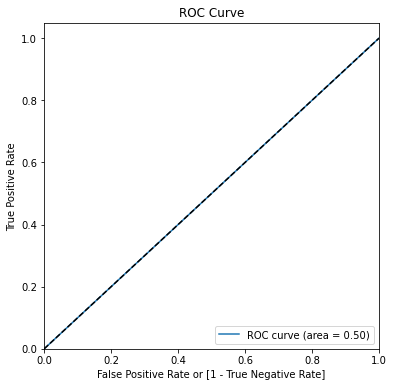

In [82]:
# ROC-AUC curve
draw_roc(Y_test, Y_pred)

We have got the accuracy score of 94.23% with the best estimator which is slightly better than the Cross Validation mean score. Also the above Roc Curve seems to be in a good shape.

Nows let's see if we can optimize the cutoff further to minimize the False Negatives

#### Optimal probability cutoff to minimize False Negatives

In [83]:
# Frame the dataset with the predicted probabilities
Y_pred_final = pd.DataFrame({'actual':Y_test,'pred_nonchurn_prob':Y_pred_proba[:,0],'pred_churn_prob':Y_pred_proba[:,1],'predicted':Y_pred})
Y_pred_final.head(5)

,actual,pred_nonchurn_prob,pred_churn_prob,predicted
id,,,,
34938,0,0.932524,0.067476,0
20052,0,0.812142,0.187858,0
28069,0,0.825678,0.174322,0
59117,0,0.815458,0.184542,0
30319,0,0.818794,0.181206,0


In [84]:
# create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    Y_pred_final[i]= Y_pred_final['pred_churn_prob'].map( lambda x: 1 if x > i else 0)
Y_pred_final.head()

,actual,pred_nonchurn_prob,pred_churn_prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
id,,,,,,,,,,,,,,
34938,0,0.932524,0.067476,0,1,0,0,0,0,0,0,0,0,0
20052,0,0.812142,0.187858,0,1,1,0,0,0,0,0,0,0,0
28069,0,0.825678,0.174322,0,1,1,0,0,0,0,0,0,0,0
59117,0,0.815458,0.184542,0,1,1,0,0,0,0,0,0,0,0
30319,0,0.818794,0.181206,0,1,1,0,0,0,0,0,0,0,0


In [85]:
# calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix( Y_pred_final['actual'], Y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.057718  0.000000  1.000000
0.1   0.1  0.237372  0.196393  0.906377
0.2   0.2  0.664265  0.674867  0.491180
0.3   0.3  0.854021  0.894697  0.189959
0.4   0.4  0.942282  1.000000  0.000000
0.5   0.5  0.942282  1.000000  0.000000
0.6   0.6  0.942282  1.000000  0.000000
0.7   0.7  0.942282  1.000000  0.000000
0.8   0.8  0.942282  1.000000  0.000000
0.9   0.9  0.942282  1.000000  0.000000


<AxesSubplot:xlabel='prob'>

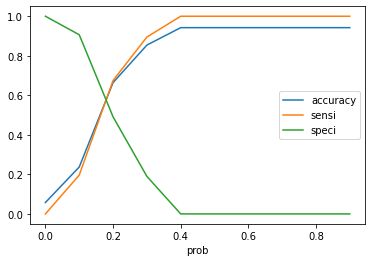

In [86]:
# plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

Now let's try with the cutoff of 0.2 and see if the False negatives can be reduced.

In [87]:
Y_pred_final['final_predicted'] = Y_pred_final['pred_churn_prob'].map( lambda x: 1 if x > 0.1 else 0)

### Final Model Evaluation

In [88]:
# Classification Report
print('\nClassification Report : \n\n', classification_report(Y_test, Y_pred_final['final_predicted']))

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_final['final_predicted']).ravel()
print('\nTN = {0}, FP = {1}, FN = {2}, TP = {3}\n\n'.format(tn, fp, fn, tp))

# Model evaluation
acc_score, roc_score, prec_score, rec_score = evaluate_model(Y_test, Y_pred_final['final_predicted'])


Classification Report : 

               precision    recall  f1-score   support

           0       0.97      0.20      0.33     12032
           1       0.06      0.91      0.12       737

    accuracy                           0.24     12769
   macro avg       0.52      0.55      0.22     12769
weighted avg       0.92      0.24      0.31     12769


TN = 2363, FP = 9669, FN = 69, TP = 668


Accuracy Score :  23.74
ROC AUC score :  55.14
Precision score :  6.46
Recall score :  90.64


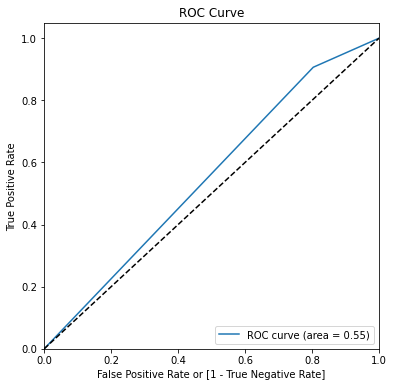

In [89]:
# ROC-AUC curve
draw_roc(Y_test, Y_pred_final['final_predicted'])

#### Modeling using Pipeline

In [90]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [91]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [94]:
pipe.fit(X_train, Y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [95]:
train_score = pipe.score(X_train, Y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.9395375247195191


In [97]:
test_score = pipe.score(X_test[new_vars], Y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.9311614065314433


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [99]:
confusion_matrix(Y_train, pipe.predict(X_train))

array([[47882,   133],
       [ 2955,   103]], dtype=int64)

In [100]:
confusion_matrix(Y_test, pipe.predict(X_test))

array([[11777,   255],
       [  624,   113]], dtype=int64)

We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [101]:
precision_score(Y_test, pipe.predict(X_test))

0.3070652173913043

In [102]:
recall_score(Y_test, pipe.predict(X_test))

0.15332428765264586

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [103]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [104]:
#Unseen Data
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


In [105]:
unseen.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 171 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [106]:
new_vars

Index(['circle_id', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon'],
      dtype='object')

Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [107]:
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

(30000, 17)

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [108]:
unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [ ]:
output.to_csv('submission_pca_lr_19Jan_5.csv',index=False)

You can now take this file and upload it as a submission on Kaggle.